# 02. Neural network classification with pytorch

In [1]:
# Data

from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state = 42)


In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X:\n {X[:5]} ")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] 
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
import pandas as pd

df = pd.DataFrame({"X1": X[:, 0],
                   "X2": X[:, 1],
                   "label" : y})

df.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


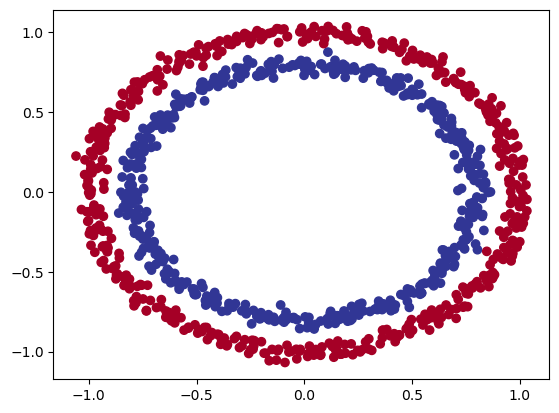

In [5]:
# Visualise

import matplotlib.pyplot as plt

plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)


In [6]:
# View the first example of features and label
X_sample = X[0]
y_sample = y[0]
 
print(f"Value for one sample of x: {X_sample} and the same for y: {y_sample}")
print(f"Shape for one sample of x: {X_sample.shape} and the same for y: {y_sample.shape}")

Value for one sample of x: [0.75424625 0.23148074] and the same for y: 1
Shape for one sample of x: (2,) and the same for y: ()


In [7]:
import torch
torch.__version__

'2.9.1+cu128'

In [8]:
# Converting numpy type into tensor

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

##  1. Splitting data


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [11]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:

1. Set up device-agnostic code so our code will run on an accelerator (GPU) if there is one  
2. Construct a model (by subclassing `nn.Module`)  
3. Define a loss function and optimizer  
4. Create a training and test loop  


In [12]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module`  
   *(almost all models in PyTorch subclass `nn.Module`)*

2. Creates 2 `nn.Linear()` layers that are capable of handling the shapes of our data  

3. Defines a `forward()` method that outlines the forward pass  
   *(or forward computation) of the model*  

4. Instantiates an instance of our model class and sends it to the target device


In [13]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1466, -0.0473],
                      [-0.1171, -0.2537],
                      [ 0.0382, -0.5512],
                      [-0.1690,  0.1884],
                      [-0.2960,  0.1138]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.0731, -0.6820,  0.0724,  0.1189, -0.0571], device='cuda:0')),
             ('1.weight',
              tensor([[-0.2122,  0.3526,  0.3430,  0.0052,  0.1189]], device='cuda:0')),
             ('1.bias', tensor([0.2335], device='cuda:0'))])

In [16]:
# Predicting a model
with torch.no_grad():
    untrained_pred = model_0(X_test.to(device))
    print(f"Length of predictions: {len(untrained_pred)}, Shape: {untrained_pred.shape}")
    print(f"Length of test: {len(X_test)}, Shape: {X_test.shape}")
    print(f"\nFirst 10 predictions: \n{untrained_pred[:10]}")
    print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[-0.1414],
        [-0.2490],
        [ 0.1431],
        [-0.2220],
        [ 0.1467],
        [ 0.0809],
        [-0.2251],
        [-0.1478],
        [ 0.1426],
        [-0.2562]], device='cuda:0')

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [17]:
# Set up loss function

loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [18]:
# Calculate 100 accuracy out of 100 samples
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## Train model 

to build a model we have to make a training loop

## 3.1 Going from raw logits → prediction probabilities → prediction labels

Our model outputs are going to be **raw logits**.

We can convert these **logits** into **prediction probabilities** by passing them through some kind of activation function  
(e.g. **sigmoid** for binary classification and **softmax** for multiclass classification).

Then we can convert our model’s **prediction probabilities** to **prediction labels** by either **rounding** them  
or taking the **`argmax()`**.


In [19]:
# view the first 5 output of the forward pass of the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1414],
        [-0.2490],
        [ 0.1431],
        [-0.2220],
        [ 0.1467]], device='cuda:0')

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [21]:
# Use the sigmoid activation function on out model logits

y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.4647],
        [0.4381],
        [0.5357],
        [0.4447],
        [0.5366]], device='cuda:0')

In [22]:
y_pred = torch.round(y_pred_prob)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5]

print(torch.eq(y_pred.squeeze(), y_pred_labels.squeeze()))

y_pred.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

# Building the training and testing loop

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 100

for epoch in range(epochs):
    model_0.train()

    # Doing the forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Applying loss fn and accuracy
    loss = loss_fn(y_logits,y_train)

    acc = accuracy_fn(y_true=y_train, y_pred = y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Back propogation
    loss.backward()

    # Optimizer step
    optimizer.step()

    ## Model evaluation
    model_0.eval()
    with torch.inference_mode():

        # forward pass for test
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate the loss and accuracy
        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true = y_test,
                          y_pred = test_pred)

    
    # See whats happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.69844 | Acc: 49.00% | Test Loss: 0.69077 | Test Acc: 54.00%
Epoch: 10 | Loss: 0.69779 | Acc: 48.75% | Test Loss: 0.69066 | Test Acc: 54.50%
Epoch: 20 | Loss: 0.69726 | Acc: 48.62% | Test Loss: 0.69060 | Test Acc: 54.00%
Epoch: 30 | Loss: 0.69681 | Acc: 48.75% | Test Loss: 0.69059 | Test Acc: 54.00%
Epoch: 40 | Loss: 0.69643 | Acc: 49.00% | Test Loss: 0.69060 | Test Acc: 54.50%
Epoch: 50 | Loss: 0.69610 | Acc: 49.12% | Test Loss: 0.69063 | Test Acc: 54.50%
Epoch: 60 | Loss: 0.69581 | Acc: 49.12% | Test Loss: 0.69067 | Test Acc: 54.00%
Epoch: 70 | Loss: 0.69556 | Acc: 48.75% | Test Loss: 0.69073 | Test Acc: 53.50%
Epoch: 80 | Loss: 0.69535 | Acc: 48.88% | Test Loss: 0.69079 | Test Acc: 53.50%
Epoch: 90 | Loss: 0.69515 | Acc: 49.25% | Test Loss: 0.69086 | Test Acc: 54.50%


# Make predicions and evaluate the model

In [24]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


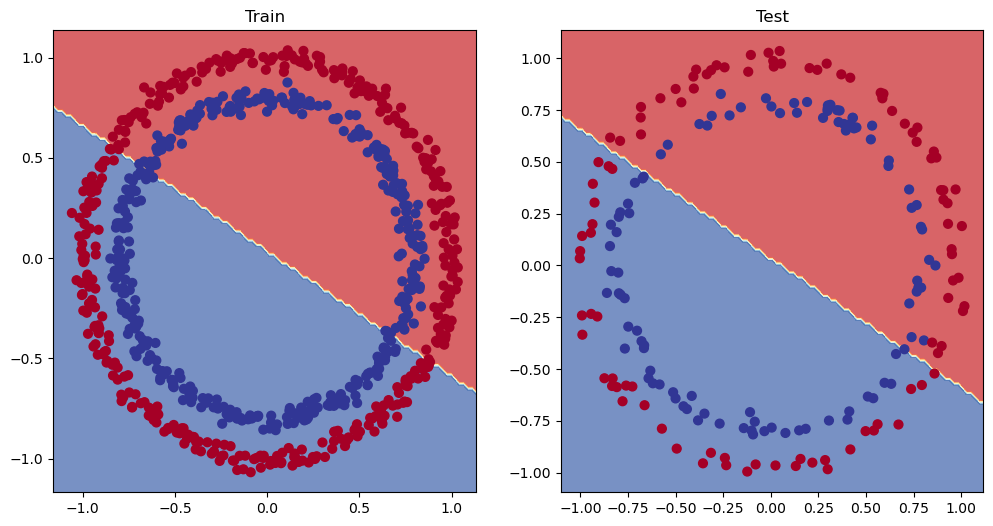

In [25]:
# Visualizing the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test,y_test)

In [26]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features = 10)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        return self.relu3(self.layer3(self.relu2(self.layer2(self.relu1(self.layer1(x))))))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu3): ReLU()
)

In [27]:
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, 

In [28]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Creating an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)

In [29]:
# Creating a training and testing loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


epochs = 100
for epoch in range(epochs):
    model_1.train()

    # Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #loss function
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred = y_pred)

    # optimizer zero grad
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    ## Evaluating model
    model_1.train()
    with torch.inference_mode():

        # Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295 | Acc: 50.00% | Test Loss: 0.69325 | Test Acc: 50.00%


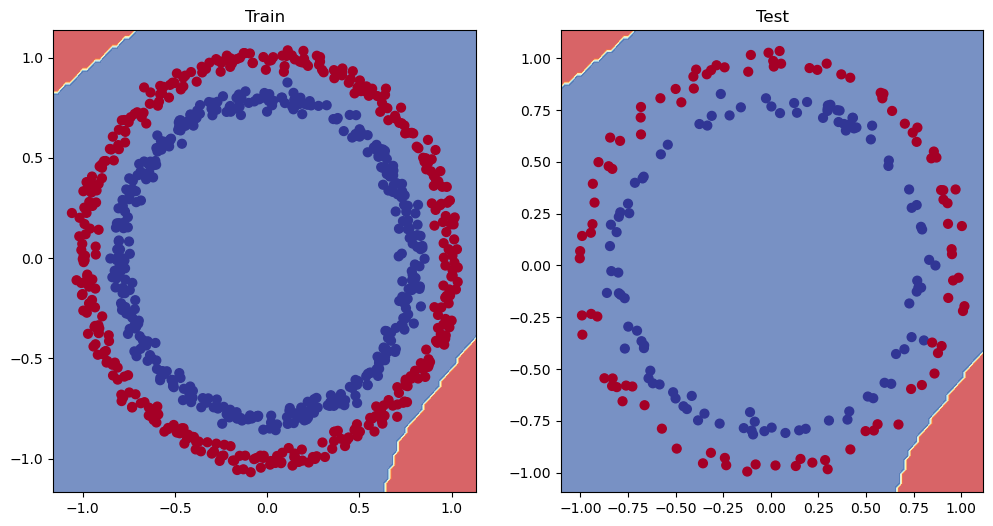

In [30]:
# Visualizing the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test,y_test)